In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

from pathlib import Path

import arviz as az
import joblib
import numpy as np
import pandas as pd
import pymc as pm
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from sqlalchemy import create_engine

from ppcluster import logger
from ppcluster.config import ConfigManager
from ppcluster.cvat import read_spatial_priors_from_cvat
from ppcluster.database import (
    get_dic_analysis_by_ids,
    get_dic_analysis_ids,
    get_image,
    get_multi_dic_data,
)
from ppcluster.mcmc import (
    assign_spatial_priors,
    compute_posterior_assignments,
    plot_1d_velocity_clustering,
    plot_spatial_priors,
)
from ppcluster.preprocessing import (
    apply_dic_filters,
    spatial_subsample,
)
from ppcluster.roi import PolygonROISelector

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)

In [2]:
SAVE_OUTPUTS = True  # Set to True to save inference results
LOAD_EXISTING = False  # Set to False to run sampling again

# MCMC parameters
DRAWS = 1000  # Number of MCMC draws
TUNE = 500  # Number of tuning steps
CHAINS = 4  # Number of MCMC chains
CORES = 4  # Number of CPU cores to use
TARGET_ACCEPT = 0.9  # Target acceptance rate for NUTS sampler

# Data selection parameters
camera_name = "PPCX_Tele"
reference_start_date = "2024-06-22"
reference_end_date = "2024-06-22"
dt_min = 72  # Minimum time difference between images in hours
dt_max = 96  # Maximum time difference between images in hours

SUBSAMPLE_FACTOR = 1  # 1=Take every n point
SUBSAMPLE_METHOD = "random"  # or 'random', 'stratified'

# Prior

# Define a specific prior probability for each sector (overrides PRIOR_STRENGTH)
# This is a dictionary where keys are sector names and values are lists of prior probabilities (Sector names must match those in the XML file)
# Sector name: [P(Cluster A), P(Cluster B), P(Cluster C)...]
# PRIOR_PROBABILITY = {
#     "A": [0.7, 0.25, 0.05, 0],
#     "B": [0.3, 0.4, 0.3, 0],
#     "C": [0.05, 0.35, 0.6, 0],
#     "D": [0.0, 0.5, 0.3, 0],
# }

SECTOR_PRIOR_FILE = Path("data/priors_3_sectors.xml")
PRIOR_PROBABILITY = {
    "A": [0.7, 0.3, 0.0],
    "B": [0.3, 0.4, 0.3],
    "C": [0.0, 0.4, 0.6],
}

# Output paths
output_dir = Path("output") / f"{camera_name}_PyMC"
output_dir.mkdir(parents=True, exist_ok=True)
base_name = (
    f"PPCX_mcmc_{camera_name}_pooled_{reference_start_date}_{reference_end_date}"
)

# Get DIC analysis metadata
dic_ids = get_dic_analysis_ids(
    db_engine,
    camera_name=camera_name,
    reference_date_start=reference_start_date,
    reference_date_end=reference_end_date,
    time_difference_min=dt_min,
    time_difference_max=dt_max,
)
if len(dic_ids) < 1:
    raise ValueError("No DIC analyses found for the given criteria")

dic_analyses = get_dic_analysis_by_ids(db_engine=db_engine, dic_ids=dic_ids)

# Get master image
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(
    master_image_id,
    camera_name=camera_name,
    config=config,
)

2025-09-19 23:19:09 | [INFO    ] Found 1 DIC analyses matching criteria


In [3]:
dic_analyses

dic_id camera_name          master_timestamp           slave_timestamp  \
0    1805   PPCX_Tele 2024-06-19 06:00:19+00:00 2024-06-22 06:00:18+00:00   

   master_image_id  slave_image_id  dt_hours  
0            34195           34223        72

In [4]:
from collections.abc import Sequence
from pathlib import Path

import numpy as np
from matplotlib.path import Path as MplPath

from ppcluster.cvat import _parse_polygon_points, read_mask_element_from_cvat


def filter_dataframe_by_masks(
    xml_source: str | Path,
    df: pd.DataFrame,
    x_col: str = "x",
    y_col: str = "y",
    exclude_labels: Sequence[str] | None = None,
) -> pd.DataFrame:
    """
    Filter dataframe using polygonal <mask> annotations from a CVAT XML.

    - If no masks are present in the CVAT file, the original dataframe is returned unchanged.
    - If masks are present, points are kept if they fall in the union of mask polygons.
    - exclude_labels can be used to ignore masks by label.
    """
    exclude = set(exclude_labels or ())
    masks = read_mask_element_from_cvat(
        xml_source, image_name=None, exclude_labels=exclude
    )
    if not masks:
        logger.info(
            "No CVAT masks found at %s — skipping CVAT mask filtering", xml_source
        )
        return df

    x_vals = df[x_col].to_numpy()
    y_vals = df[y_col].to_numpy()
    pts_xy = np.column_stack((x_vals, y_vals))
    include_mask = np.zeros(len(df), dtype=bool)

    for mask_info in masks:
        label = mask_info.get("label", "")
        pts_str = mask_info.get("points", None)
        if not pts_str:
            logger.debug("Mask '%s' has no 'points' attribute; skipping", label)
            continue
        try:
            verts = _parse_polygon_points(pts_str)  # (N,2)
            if verts.shape[0] < 3:
                logger.debug("Mask '%s' has fewer than 3 vertices; skipping", label)
                continue
            # ensure closed polygon for MplPath.contains_points behaviour
            if not np.allclose(verts[0], verts[-1]):
                verts = np.vstack([verts, verts[0]])
            path = MplPath(verts)
            hit = path.contains_points(pts_xy)
            include_mask |= hit
            logger.info("Mask '%s': %d points inside", label, int(hit.sum()))
        except Exception as exc:
            logger.warning("Failed to parse/apply mask '%s': %s", label, exc)
            continue

    df_filtered = df.loc[include_mask].reset_index(drop=True)
    logger.info("Data shape after CVAT mask filtering: %s", df_filtered.shape)
    return df_filtered


In [5]:
# Fetch DIC data
out = get_multi_dic_data(
    dic_ids,
    stack_results=False,
    config=config,
)
logger.info(f"Found stack of {len(out)} DIC dataframes. Run filtering...")

# Apply filter for each df in the dictionary and then stack them
filter_kwargs = dict(
    filter_outliers=config.get("dic.filter_outliers"),
    tails_percentile=config.get("dic.tails_percentile"),
    min_velocity=config.get("dic.min_velocity"),
    # apply_2d_median=config.get("dic.apply_2d_median"),
    # median_window_size=config.get("dic.median_window_size"),
    # median_threshold_factor=config.get("dic.median_threshold_factor"),
    # apply_2d_gaussian=config.get("dic.apply_2d_gaussian", True),
    # gaussian_sigma=config.get("dic.gaussian_sigma", 1.0),
)
processed = []
for src_id, df_src in out.items():
    try:
        processed.append(apply_dic_filters(df_src, **filter_kwargs))
    except Exception as exc:
        logger.warning("Filtering failed for %s: %s", src_id, exc)
if not processed:
    raise RuntimeError("No dataframes left after filtering.")
df = pd.concat(processed, ignore_index=True)
logger.info("Data shape after filtering and stacking: %s", df.shape)

2025-09-19 23:19:10 | [INFO    ] Fetched DIC data for id 1805 with 3927 points
2025-09-19 23:19:10 | [INFO    ] Found stack of 1 DIC dataframes. Run filtering...
2025-09-19 23:19:10 | [INFO    ] Starting DIC filtering pipeline with 3927 points
2025-09-19 23:19:10 | [INFO    ] Percentile filtering: 3927 -> 3848 points (removed 79 outliers)
2025-09-19 23:19:10 | [INFO    ] Min velocity filtering: 3848 -> 3093 points (removed 755 points below 1)
2025-09-19 23:19:10 | [INFO    ] DIC filtering pipeline completed: 3927 -> 3093 points (removed 834 total)
2025-09-19 23:19:10 | [INFO    ] Data shape after filtering and stacking: (3093, 5)


In [6]:
# Apply ROI filter
# selector = PolygonROISelector.from_file(config.get("data.roi_path"))
# df = selector.filter_dataframe(df, x_col="x", y_col="y")
# df2 = filter_dataframe_by_masks(SECTOR_PRIOR_FILE, df, x_col="x", y_col="y")
# logger.info(f"Data shape after filtering: {df2.shape}")

In [7]:
# Apply ROI filter
selector = PolygonROISelector.from_file(config.get("data.roi_path"))
df = selector.filter_dataframe(df, x_col="x", y_col="y")

# Apply subsampling AFTER ROI filtering
if SUBSAMPLE_FACTOR > 0:
    df_subsampled = spatial_subsample(
        df, n_subsample=SUBSAMPLE_FACTOR, method=SUBSAMPLE_METHOD
    )
    df = df_subsampled
    logger.info(f"Data shape after subsampling: {df.shape}")

# === FEATURE PREPARATION ===
# Do not need anymore to compute features here, we use velocity magnitude and direction directly
# df_features = preproc_features(df)

# Extact feature matrix
variables_names = config.get("clustering.variables_names")
logger.info(f"Using features: {variables_names}")
X = df[variables_names].values
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
logger.info(f"Feature matrix shape: {X_scaled.shape}")

2025-09-19 23:19:10 | [INFO    ] Filtered 3093 points to 2690 points inside polygon
2025-09-19 23:19:10 | [INFO    ] Data shape after subsampling: (2690, 5)
2025-09-19 23:19:10 | [INFO    ] Using features: ['V']
2025-09-19 23:19:10 | [INFO    ] Feature matrix shape: (2690, 1)


Subsampled from 2690 to 2690 points (100.0%)


In [8]:
from ppcluster.preprocessing import apply_2d_gaussian_filter

sigma = 5
df_smooth = apply_2d_gaussian_filter(df, sigma=sigma)

2025-09-19 23:19:10 | [INFO    ] Applying 2D Gaussian filter (u,v,V): sigma=5
2025-09-19 23:19:10 | [INFO    ] Estimated grid spacing: 64.00
2025-09-19 23:19:11 | [INFO    ] Created 2D grid: (75, 51), 2690 valid points
2025-09-19 23:19:11 | [INFO    ] apply_2d_gaussian_filter: smoothed values assigned, NaN mapped points (total components)=0


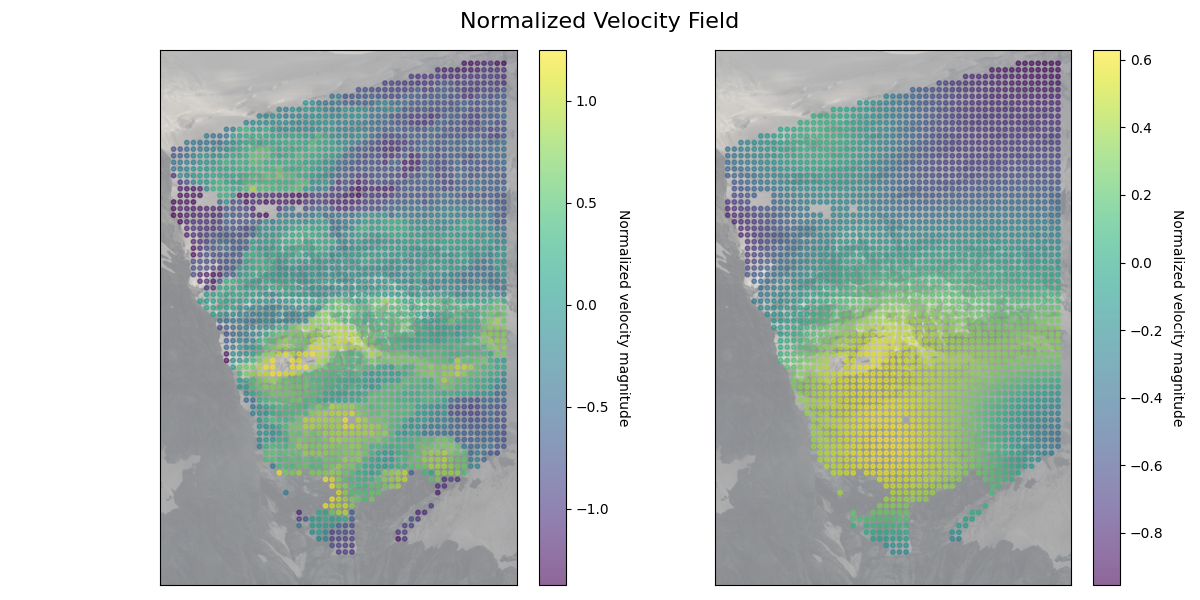

In [9]:
# Plot normalized velocity field


def plot_sfv(x, y, values, img=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    if img is not None:
        ax.imshow(img, alpha=0.5, cmap="gray")
    q = ax.scatter(
        x,
        y,
        c=values,
        cmap="viridis",
        s=10,
        alpha=0.6,
    )
    cbar = plt.colorbar(q, ax=ax, fraction=0.05, pad=0.04)
    cbar.set_label("Normalized velocity magnitude", rotation=270, labelpad=15)
    ax.set_xticks([])
    ax.set_yticks([])
    return ax


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Normalized Velocity Field", fontsize=16)
axes[0] = plot_sfv(
    df["x"].to_numpy(), df["y"].to_numpy(), X_scaled, img=img, ax=axes[0]
)
axes[1] = plot_sfv(
    df_smooth["x"].to_numpy(),
    df_smooth["y"].to_numpy(),
    scaler.transform(df_smooth[variables_names].to_numpy()),
    img=img,
    ax=axes[1],
)
plt.tight_layout()
plt.show()

In [10]:
df = df_smooth

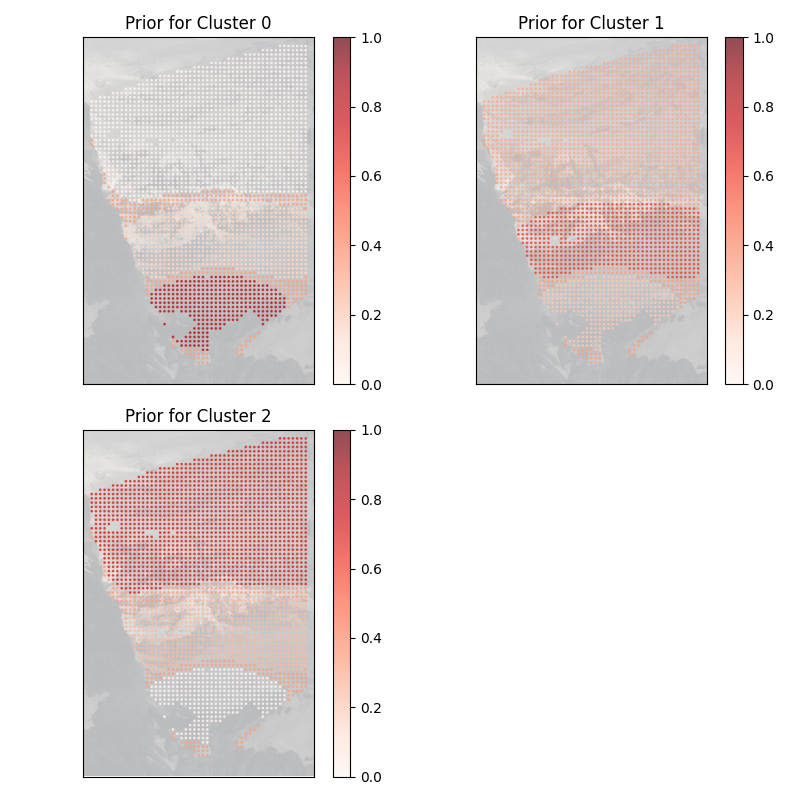

In [12]:
# Assign spatial priors to points
sectors = read_spatial_priors_from_cvat(SECTOR_PRIOR_FILE, image_name=None)
prior_probs = assign_spatial_priors(df, sectors, prior_probs=PRIOR_PROBABILITY)
plot_spatial_priors(df, prior_probs, img=img);

In [ ]:
# # Simple, not marginalized model (z discrete) --> slower sampling, but direct cluster assignments

# n_features = X_scaled.shape[1]
# n_data = X_scaled.shape[0]
# k = len(sectors)  # number of clusters = number of sectors
#
# with pm.Model(
#     coords={"cluster": range(k), "feature": range(n_features), "obs": range(ndata)}
# ) as simple_model:
#     # Cluster means
#     μ = pm.Normal("μ", mu=0, sigma=1, dims=("cluster", "feature"))

#     # Cluster standard deviations (diagonal covariance)
#     σ = pm.HalfNormal("σ", sigma=0.5, dims=("cluster", "feature"))

#     # Cluster assignments with spatial priors
#     z = pm.Categorical("z", p=prior_probs, dims="obs")

#     # Likelihood: each point comes from its assigned cluster
#     observations = pm.Normal(
#         "x_obs", mu=μ[z], sigma=σ[z], observed=X_scaled, dims=("obs", "feature")
#     )

# with simple_model:
#     prior_samples = pm.sample_prior_predictive(100)

# fig, ax = plt.subplots(figsize=(8, 4))
# az.plot_dist(
#     X_scaled,
#     kind="hist",
#     color="C1",
#     hist_kwargs={"alpha": 0.6},
#     label="observed",
# )
# az.plot_dist(
#     prior_samples.prior_predictive["x_obs"],
#     kind="hist",
#     hist_kwargs={"alpha": 0.6},
#     label="simulated",
# )
# plt.xticks(rotation=45);

In [14]:
# Marginalized mixture model (no discrete z) --> faster sampling, but no direct cluster assignments
n_features = X_scaled.shape[1]
n_data = X_scaled.shape[0]
k = len(sectors)  # number of clusters = number of sectors

with pm.Model(
    coords={"obs": range(n_data), "cluster": range(k), "feature": range(n_features)}
) as model:
    obs_data = pm.Data("obs_data", X_scaled, dims=("obs", "feature"))
    prior_w = pm.Data(
        "prior_w", prior_probs.reshape(n_data, k), dims=("obs", "cluster")
    )

    mu = pm.Normal("mu", 0, 1, dims=("cluster", "feature"))
    sigma = pm.HalfNormal("sigma", 0.5, dims=("cluster", "feature"))

    # Log weights with small constant to avoid log(0)
    log_w = pm.Deterministic(
        "log_w", pm.math.log(prior_w + 1e-12), dims=("obs", "cluster")
    )

    # Per-cluster log-likelihood
    x_centered = (obs_data[:, None, :] - mu[None, :, :]) / sigma[None, :, :]
    logp_feat = -0.5 * (
        pm.math.log(2 * np.pi) + 2 * pm.math.log(sigma[None, :, :]) + x_centered**2
    )
    logp_clusters = logp_feat.sum(axis=2)  # (obs, cluster)

    # Mixture log likelihood (marginalized over clusters)
    log_mix = pm.logsumexp(logp_clusters + log_w, axis=1)  # (obs,)

    # Total logp as Potential
    pm.Potential("mixture_logp", log_mix.sum())

logger.info("Marginalized mixture model created (no discrete z).")

# Sampling (now NUTS can be used for mu, sigma)
posterior_path = output_dir / f"{base_name}_posterior.idata.nc"
if LOAD_EXISTING is False or not posterior_path.exists():
    with model:
        logger.info("Starting MCMC sampling...")
        idata = pm.sample(
            target_accept=TARGET_ACCEPT,
            draws=DRAWS,
            tune=TUNE,
            chains=CHAINS,
            cores=CORES,
            random_seed=RANDOM_SEED,
        )
    logger.info("Sampling completed!")

    # save the posterior InferenceData object and the scaler
    if SAVE_OUTPUTS:
        az.to_netcdf(idata, posterior_path)
        joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")
        logger.info(f"Outputs saved to {output_dir}")
else:
    logger.info("Loading existing posterior InferenceData object...")
    idata = az.from_netcdf(posterior_path)


2025-09-19 23:20:35 | [INFO    ] Marginalized mixture model created (no discrete z).
2025-09-19 23:20:35 | [INFO    ] Starting MCMC sampling...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 20 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
2025-09-19 23:20:59 | [INFO    ] Sampling completed!
2025-09-19 23:21:01 | [INFO    ] Outputs saved to output/PPCX_Tele_PyMC


In [15]:
print(az.summary(idata, var_names=["mu", "sigma"]))

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu[0, 0]     0.635  0.066   0.503    0.704      0.031    0.018       7.0   
mu[1, 0]     0.204  0.041   0.156    0.285      0.019    0.011       7.0   
mu[2, 0]    -0.554  0.016  -0.582   -0.521      0.000    0.000    4356.0   
sigma[0, 0]  0.294  0.091   0.222    0.467      0.045    0.026       7.0   
sigma[1, 0]  0.309  0.027   0.254    0.344      0.012    0.006       7.0   
sigma[2, 0]  0.411  0.011   0.389    0.431      0.002    0.000      42.0   

             ess_tail  r_hat  
mu[0, 0]         29.0   1.53  
mu[1, 0]         30.0   1.53  
mu[2, 0]       3484.0   1.00  
sigma[0, 0]      29.0   1.53  
sigma[1, 0]      29.0   1.53  
sigma[2, 0]     225.0   1.07  


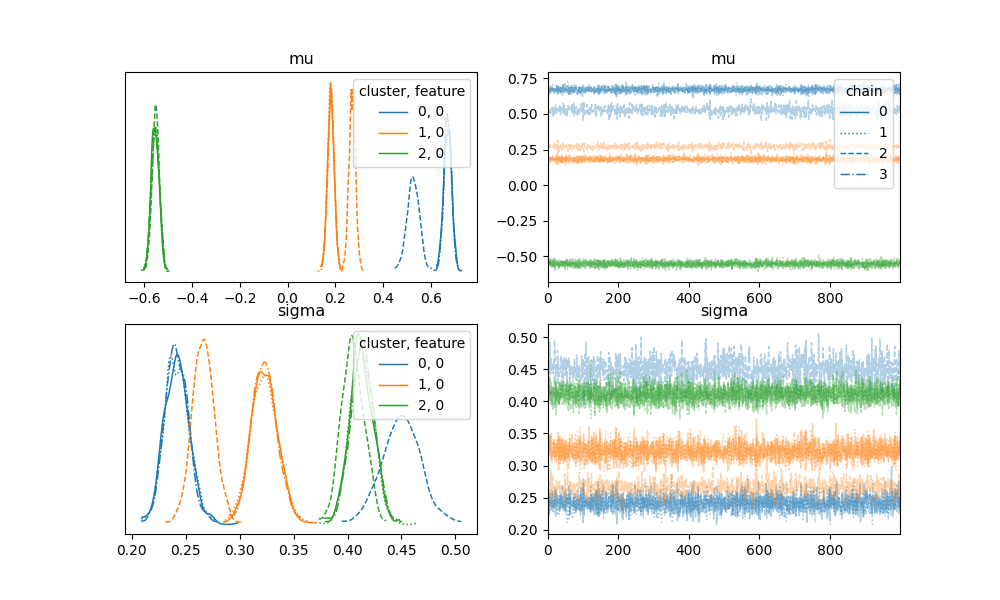

In [16]:
# Plot trace plots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
az.plot_trace(idata, var_names=["mu", "sigma"], axes=axes, compact=True, legend=True)
if SAVE_OUTPUTS:
    fig.savefig(output_dir / f"{base_name}_trace_plots.png", dpi=150)

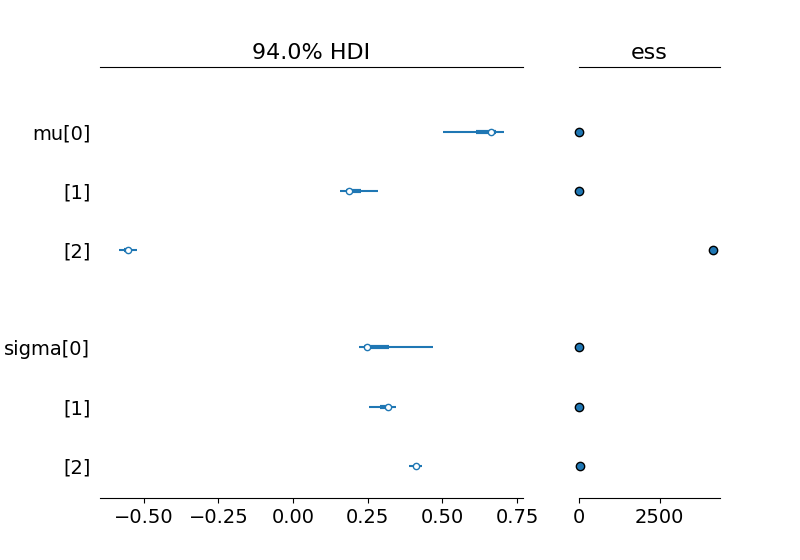

In [17]:
az.plot_forest(idata, var_names=["mu", "sigma"], combined=True, ess=True);

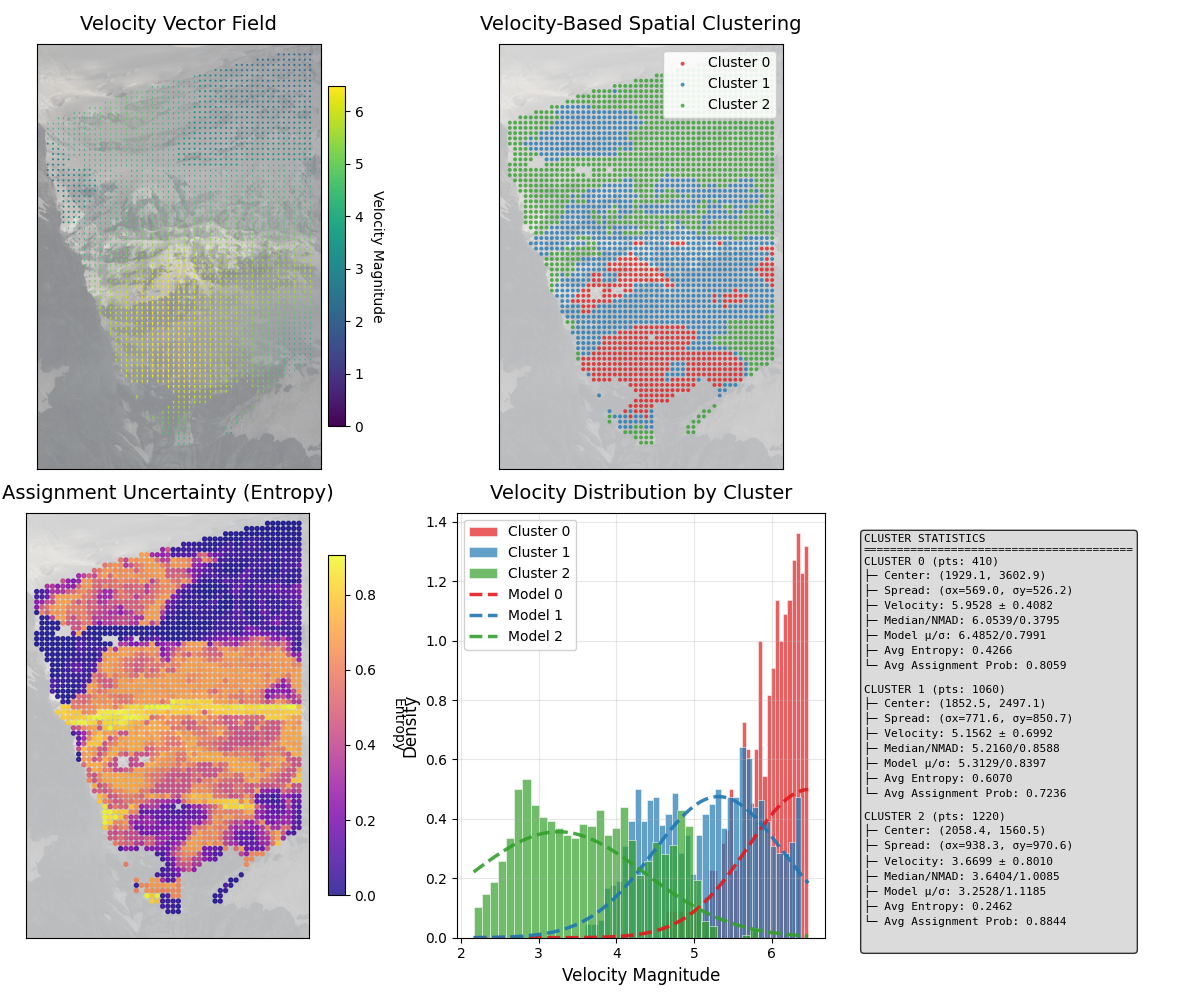

In [18]:
## === POSTERIOR ANALYSIS: ASSIGN POINTS TO CLUSTERS ===

# compute cluster assignments (subsample 200 posterior draws to save time)
posterior_probs, cluster_pred, uncertainty = compute_posterior_assignments(
    idata, X_scaled, prior_probs, n_posterior_samples=200
)
fig, uncertainty, stats = plot_1d_velocity_clustering(
    df,
    img,
    idata=idata,
    cluster_pred=cluster_pred,
    posterior_probs=posterior_probs,
    scaler=scaler,
)
if SAVE_OUTPUTS:
    fig.savefig(output_dir / f"{base_name}_results.png", dpi=300, bbox_inches="tight")